In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product
import random
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
# TODO There is also .complex_roots() for finding the others
# TODO Or use .roots(ring=CC) to find complex roots as well
# |                  sage: f.roots(ring=CC)   # note -- low order bits slightly different on ppc.
# |                  [(1.00000000000000, 1), (-0.500000000000000 - 0.86602540378443...*I, 1), (-0.500000000000000 + 0.86602540378443...*I, 1)]


def find_all_real_roots(expr, max_iterations=10000):
    degr = expr.degree(var('x'))
    zeros = []
    iteration = 0
    for root in expr.roots():
        for i in range(root[1]):
            zeros.append(root[0])
    if not len(zeros) == degr:
        while not len(zeros) == degr or iteration >= max_iterations:
            iteration += 1
            max_search = randrange(sys.maxsize)
            min_search = min_search - int(sys.maxsize*0.1)
            try:
                root = find_root(expr, min_search, max_search)
                zeros.append(root)
            except:
                continue
    return zeros

In [4]:
# TODO Nochmal durchlaufen lassen
def get_prepared_SNF(input_matrix, left_var=var('dx1'), right_var=var('dx2')):
    d, u, v = input_matrix.smith_form()
    (r, c) = np.shape(d)
    if r > c:
        assert "More rows than columns in diagonal matrix D"
    if not d == u*input_matrix*v:
        assert "The calculation of the Smith form failed or is not possible"
    # TODO try out using e.change_variable_name(left_var)
    V_left = matrix([[e.change_variable_name(left_var) for e in row] for row in v])
    V_right_transpose = matrix([[e.change_variable_name(right_var) for e in row] for row in v.transpose()])
    #V_left = matrix([[e.substitute(left_var) for e in row] for row in v])
    #V_right_transpose = matrix([[e.substitute(right_var) for e in row] for row in v.transpose()])
    row = [None] * c
    pre_diff_kernel_matrix = []
    for i in range(c):
        temp = copy(row)
        if i < r and d[i][i] == 0 or i >= r:
            temp[i] = Diff_SE_kernel(var=0, length=0)
        # Real roots case (i.e. exp kernel)
        elif i < r and not SR(str(d[i][i])).is_numeric():
            list_of_summands = SR(str(d[i][i])).factor_list()
            if len(list_of_summands) > 1:
                raise "I can't deal with that right now"
            kernel = None
            for summand in list_of_summands:
                roots = summand[0].roots()
                for root in roots:
                    if root[1] > 1:
                        raise "I can't deal with that right now"
                    if root[0].imag() == 0:
                        factor = summand[0].content(x)
                        exp_coeff = root[0]
                        if kernel is None:
                            kernel = exp_kernel(torch.tensor(float(factor)), torch.tensor(float(exp_coeff)))
            temp[i] = kernel
        # TODO with poly.content(x) I can potentially get the coefficients in the front and make the stuff cleaner
        #
        #    find_all_real_roots(d[i][i])
        # Complex roots case (i.e. sin/cos kernel)
        #elif something_else:
        # Mixed roots case?
        #elif something_completely_different:
        
            
        pre_diff_kernel_matrix.append(temp)
    return pre_diff_kernel_matrix, V_left, V_right_transpose

In [5]:
a = SR('x^3')


In [6]:
poly = SR(str('3*(x1^3-1)'))
print(poly.simplify_full())
print(poly.expand())
print(poly.coefficients())
print(poly.operands())
print(poly.roots())
print(poly.factor_list())
print(poly.content(x1))
print(poly.imag())


3*x1^3 - 3
3*x1^3 - 3
[[-3, 0], [3, 3]]
[3*x1^3, -3]
[(1/2*I*sqrt(3) - 1/2, 1), (-1/2*I*sqrt(3) - 1/2, 1), (1, 1)]
[(x1^2 + x1 + 1, 1), (x1 - 1, 1), (3, 1)]
3
-3*imag_part(x1)^3 + 9*imag_part(x1)*real_part(x1)^2


In [7]:

R.<x> = QQ[]
m = x^2*matrix(R, 2,3,[1, 0, 1, 1, 0, 0]) +x* matrix(R, 2,3,[-1, -1, -2, -2, 1, 1]) + matrix(R, 2,3,[0, 1, 1, 0, 0, -1])


dx1 = var('dx1')
dx2 = var('dx2')
#L = [[2, 1, 0], [3/2, -1/2*dx1 + 2, -1], [-dx1 - 1, dx1^2 - 3*dx1, 2*dx1]]
#R = [[2, 3/2, -dx2 - 1], [1, -1/2*dx2 + 2, dx2^2 - 3*dx2], [0, -1, 2*dx2]]
#L = matrix(L)
#R = matrix(R)

#T, L, R = get_prepared_SNF(m, dx1, dx2)
#print(m)

#print(T)
#print(L)
#print(R)
A = matrix(R, 2, 3, [x, -x^2+x-1, x-2, 2-x, x^2-x-1, -x])
#print("---")
d, u, v = A.smith_form()
#d[1][1].roots()
print(u)

[  1/2   1/2]
[x - 2     x]


In [8]:

a = x^2 - 1
print(a.roots())
#find_root(a, -2, 10)


[(1, 1), (-1, 1)]


In [9]:
randrange(sys.maxsize)- int(sys.maxsize*0.1)

6672341672043243971

In [10]:
train_x = torch.linspace(float(0), float(5), int(10))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(6)*train_x + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(5)) + torch.randn(train_x.size()) * float(0.2)
#two = int(60)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
#one = torch.exp(train_x) + torch.randn(train_x.size()) * float(0.2)
#two = torch.exp(train_x) + torch.randn(train_x.size()) * float(0.2)
#three = torch.exp(train_x) + torch.randn(train_x.size()) * float(0.2)


noise = float(0.1)
# ODE_GP_Example.mw
one = torch.div(torch.cos(train_x) - torch.sin(train_x), int(2)) - torch.div(torch.exp(train_x), int(10)) + torch.randn(train_x.size()) * float(noise)
two = torch.cos(train_x) + torch.randn(train_x.size()) * float(noise)
three = torch.div(- torch.cos(train_x) - torch.sin(train_x), int(2)) - torch.div(torch.exp(train_x), int(10)) + torch.randn(train_x.size()) * float(noise)



train_y = torch.stack([one, two, three], int(-1))


In [11]:


# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

In [12]:

len(train_y.shape)

2

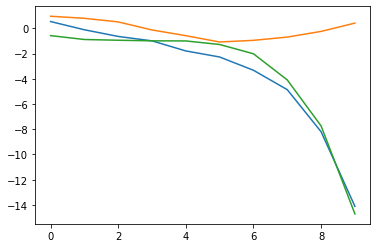

In [13]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [14]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [15]:
dx1, a, b = var('dx1, a, b')
p = dx1*a + dx1*b + dx1^2
p.operands()
[('+' in str(op) or '^' in str(op)) for op in p.operands()]
#[not(not op in [sage.rings.integer.Integer, sage.rings.real_mpfr.RealLiteral] and op.has(d_var)) and ('+' in str(op) or '^' in str(op)) for op in p.operands()]

[False, False, True]

In [16]:
d_var=(dx1)
if type(p) in [sage.symbolic.expression.Expression] and any(not(not op in [sage.rings.integer.Integer, sage.rings.real_mpfr.RealLiteral] and op.has(d_var)) and ('+' in str(op) or '^' in str(op)) for op in p.operands()):
    print("Damn")

In [17]:
F.<a> = FunctionField(QQ)
R.<x> = F[]
R.<dx1> = F[]
#e = x+a
#e.substitute(dx1)
R

Univariate Polynomial Ring in dx1 over Rational function field in a over Rational Field

In [18]:
F.<a> = FunctionField(QQ)
F.<b> = FunctionField(F)
R.<x> = F[]
#F.base_extend(R)
#P.<x> = SR[]
#R.<x> = F[]
#R.base_extend()
m1 = matrix(R, 2, 3, [[a, b, x], [1, a+b, x]])
for row in m1:
    for e in row:
        print(SR(str(e)).operands())



[]
[]
[]
[]
[a, b]
[]


In [19]:



class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=3
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        a, b, q, dx1, dx2, x = var('a, b, q, dx1, dx2, x')
        
        # Control example 1 (AirControl3)
        """
        variables=[]
        F.<a> = FunctionField(QQ)
        variables.append(f"{F.variable_name()}")
        F.<b> = FunctionField(F)
        variables.append(f"{F.variable_name()}")
        R.<x> = F[]
        variables.append(f"{R.variable_name()}")
        R.<dx1> = F[]
        variables.append(f"{R.variable_name()}")
        R.<dx2> = F[]
        variables.append(f"{R.variable_name()}")
        A = matrix(R, 2, 3, [x+a, -a, -1, -b, x+b, 0])
        """
        
        # Control example 2 (ODE_GP_Example)
        variables=[]
        F.<a> = FunctionField(QQ)
        variables.append(f"{F.variable_name()}")
        R.<x> = F[]
        variables.append(f"{F.variable_name()}")
        R.<x> = QQ[]
        variables.append(f"{F.variable_name()}")
        A = matrix(R, 2, 3, [x, -x^2+x-1, x-2, 2-x, x^2-x-1, -x])
        
        
        #m = x^2*matrix(R, 2,3,[1, 0, 1, 1, 0, 0]) +x* matrix(R, 2,3,[-1, -1, -2, -2, 1, 1]) + matrix(R, 2,3,[0, 1, 1, 0, 0, -1])
        
        T, L, R = get_prepared_SNF(A, dx1, dx2)
       
        #L = matrix(3, 3, (0, 0, dx1+b, 0, 0, b, 0, 0, dx1*a + dx1*b + dx1^2))
        #R = matrix(3, 3, (dx2^2+dx2*b+dx2*a, b, dx2+b, 0, 0, 0, 0, 0, 0))
        p = DiffMatrixKernel(T)

        print(L)
        print("---")
        print(R)
        print("---")
        print(T)
        print("---")
        
        #p = DiffMatrixKernel([[None, None, None], [None, None, None], [None, None, kernel]])
        #p = DiffMatrixKernel([[kernel, None], [None, None]])

        self.covar_module = p.diff(left_matrix=L, right_matrix=R, var_dict=variables)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

# Likelihood nochmal mit Noise constraint = E-20 durchlaufen lassen und auf quasi 0 setzen
from gpytorch.constraints import GreaterThan
local_noise_constraint = GreaterThan(float(1e-20))
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3, noise_constraint=local_noise_constraint)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001), float(0.0001), float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(1e-19)))
model = MultitaskGPModel(train_x, train_y, likelihood)
print(model.covar_module)

List of all kernels: [exp_kernel(), Diff_SE_kernel()]
[        1      -1/4 2*dx1 + 2]
[        0         0         4]
[        0      -1/4 2*dx1 - 2]
---
[        1         0         0]
[     -1/4         0      -1/4]
[2*dx2 + 2         4 2*dx2 - 2]
---
[[None, None, None], [None, exp_kernel(), None], [None, None, Diff_SE_kernel()]]
---
i
0
left
(1, -1/4, 2*dx1 + 2)
right
(1, -1/4, 2*dx2 + 2)
Result kernel
AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_exp_kernel()
    (1): diffed_SE_kernel()
  )
)
i
1
left
(1, -1/4, 2*dx1 + 2)
right
(0, 0, 4)
Result kernel
AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_exp_kernel()
    (1): diffed_SE_kernel()
  )
)
i
2
left
(1, -1/4, 2*dx1 + 2)
right
(0, -1/4, 2*dx2 - 2)
Result kernel
AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_exp_kernel()
    (1): diffed_SE_kernel()
  )
)
i
3
left
(0, 0, 4)
right
(1, -1/4, 2*dx2 + 2)
Result kernel
AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_exp_kernel()
    (1): diffed_S

In [20]:
w0 = SR.wild(0)
w1 = SR.wild(1)
w2 = SR.wild(2)

a, b, c, x = var('a, b, c, x') 

polynomial = a**2*x**2
# Check for a**n things -> needs coefficient splitting
#polynomial = a**2*x**2
#any(not p.has(x) for p in polynomial.find(w0**w1))
# Check for b/a etc. -> needs coefficient splitting
polynomial = a*b*x * x**2
polynomial.coefficients(x)
#polynomial.coefficients(x)[0][0].find(w0/w1)

[[a*b, 3]]

In [21]:
model.likelihood._set_noise(torch.tensor(float(0.0001)))

In [22]:
#model.covar_module.a.data = torch.tensor(float(2.))
#model.covar_module.b.data = torch.tensor(float(2.))

In [23]:
#data = torch.Tensor([1, 0.01])
#K = model.covar_module(test_x).evaluate()
#K == K.T
#print(torch.norm(K-K.T))

In [24]:
with gpytorch.settings.fast_pred_var():
    model.eval()
    likelihood.eval()
    data = torch.Tensor([1, 0.01])
    output = model(data)
    output.covariance_matrix
# NIPS 2018 Paper zur Invertierung

In [25]:
output.covariance_matrix == output.covariance_matrix.T

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [26]:
import_statements(PolynomialRing)

from sage.rings.polynomial.polynomial_ring_constructor import PolynomialRing


In [27]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(150)
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-4), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


Text(0.5, 1.0, 'Prior')

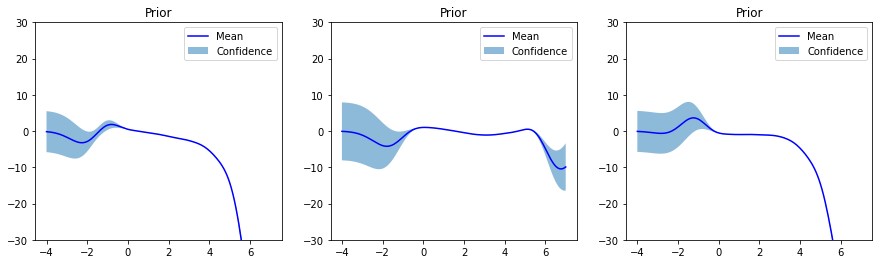

In [28]:
f, (y1_ax, y2_ax, y3_ax) = plt.subplots(int(1), int(3), figsize=(int(15), int(4)))

# Plot training data as black stars
#y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Mean', 'Confidence'])
y1_ax.set_title('Prior')

# Plot training data as black stars
#y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Mean', 'Confidence'])
y2_ax.set_title('Prior')

# Plot training data as black stars
#y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y3_ax.plot(test_x.numpy(), mean[:, 2].numpy(), 'b')
# Shade in confidence
y3_ax.fill_between(test_x.numpy(), lower[:, 2].numpy(), upper[:, 2].numpy(), alpha=0.5)
y3_ax.set_ylim([-30, 30])
y3_ax.legend(['Mean', 'Confidence'])
y3_ax.set_title('Prior')


In [29]:
for p in model.named_parameters():
    print(p)

('likelihood.raw_task_noises', Parameter containing:
tensor([-9.2103, -9.2103, -9.2103], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-9.2103], requires_grad=True))
('covar_module.a', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.10989319072.var', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.10989319072.length', Parameter containing:
tensor(0., requires_grad=True))


In [30]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(100)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    print(f"{i+1}/{training_iter}")
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    optimizer.step()

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [31]:
def coeffs(given_n):
    # See http://oeis.org/A096713
    real_n = int(given_n/2)
    m, k = var('m, k')
    # even
    # T(2*m, k) = (-1)^(m+k)*(2*m)!*2^(k-m)/((m-k)!*(2*k)!), k = 0..m.
    if given_n % 2 == 0:
        # This notation is only valid in iPython
        #T(m,k) = factorial(2*m)*2^(k-m)/(factorial(m-k)*factorial(2*k))
        # As an actual Python file I need to use:
        T = lambda m, k : (-1)**(m+k)*factorial(2*m)*2**(k-m)/(factorial(m-k)*factorial(2*k))
    # odd
    # T(2*m+1, k) = (-1)^(m+k)*(2*m+1)!*2^(k-m)/((m-k)!*(2*k+1)!), k = 0..m. (End)
    else:
        # See above
        #T(m,k) = factorial(2*m+1)*2^(k-m)/(factorial(m-k)*factorial(2*k+1))
        T = lambda m, k: (-1)**(m+k)*factorial(2*m+1)*2**(k-m)/(factorial(m-k)*factorial(2*k+1))
    return [int(T(real_n, k)) for k in range(real_n+1)]


In [32]:
for i in range(10):
    print(coeffs(i))

[1]
[1]
[-1, 1]
[-3, 1]
[3, -6, 1]
[15, -10, 1]
[-15, 45, -15, 1]
[-105, 105, -21, 1]
[105, -420, 210, -28, 1]
[945, -1260, 378, -36, 1]


In [33]:
likelihood
#torch.autograd.functional.hessian(likelihood, train_x)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-20)
  (raw_noise_constraint): GreaterThan(1.000E-20)
)

In [34]:
for parameter in model.named_parameters():
    print(parameter)


('likelihood.raw_task_noises', Parameter containing:
tensor([-5.4371, -6.1746, -5.5930], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-5.7448], requires_grad=True))
('covar_module.a', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.10989319072.var', Parameter containing:
tensor(-2.8722, requires_grad=True))
('covar_module.10989319072.length', Parameter containing:
tensor(0.5309, requires_grad=True))


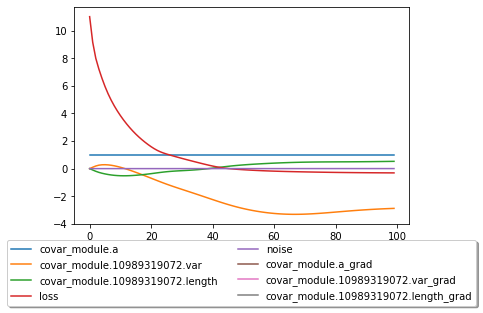

In [35]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [36]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([0.0032], grad_fn=<AddBackward0>)
tensor([0.0043, 0.0021, 0.0037], grad_fn=<AddBackward0>)


In [37]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [38]:
for parameter in model.named_parameters():
    print(parameter)
    


('likelihood.raw_task_noises', Parameter containing:
tensor([-5.4371, -6.1746, -5.5930], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-5.7448], requires_grad=True))
('covar_module.a', Parameter containing:
tensor(1., requires_grad=True))
('covar_module.10989319072.var', Parameter containing:
tensor(-2.8722, requires_grad=True))
('covar_module.10989319072.length', Parameter containing:
tensor(0.5309, requires_grad=True))


In [47]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(100)
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.prior_mode(True):
    test_x = torch.linspace(float(0), float(5), number_of_samples)
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


In [40]:
torch.count_nonzero(outputs.covariance_matrix == outputs.covariance_matrix.T)


tensor(90000)

Text(0.5, 1.0, 'Prior')

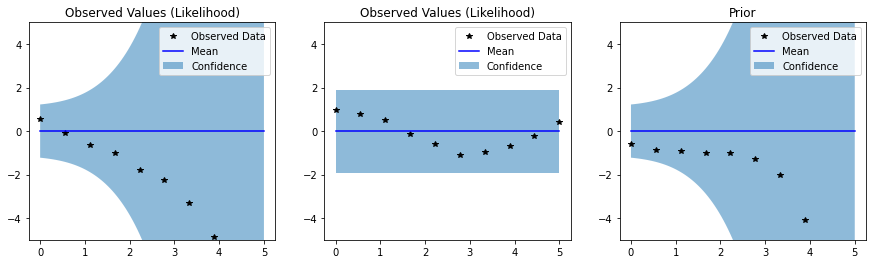

In [48]:
f, (y1_ax, y2_ax, y3_ax) = plt.subplots(int(1), int(3), figsize=(int(15), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-5, 5])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-5, 5])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y3_ax.plot(train_x.detach().numpy(), train_y[:, 2].detach().numpy(), 'k*')
# Predictive mean as blue line
y3_ax.plot(test_x.numpy(), mean[:, 2].numpy(), 'b')
# Shade in confidence
y3_ax.fill_between(test_x.numpy(), lower[:, 2].numpy(), upper[:, 2].numpy(), alpha=0.5)
y3_ax.set_ylim([-5, 5])
y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
#y3_ax.legend(['Mean', 'Confidence'])
y3_ax.set_title('Prior')



In [42]:
truth_vector = (outputs.covariance_matrix == outputs.covariance_matrix.T).flatten()
true_count = 0
for entry in truth_vector:
    if entry:
        true_count += 1
float(true_count / len(truth_vector))*100
torch.linalg.eig(outputs.covariance_matrix)

torch.return_types.linalg_eig(
eigenvalues=tensor([ 6.9715e-02+0.j,  6.6931e-02+0.j,  6.4499e-02+0.j,  5.8224e-02+0.j,
         4.6405e-02+0.j,  3.6325e-02+0.j,  2.7769e-02+0.j,  1.3107e-02+0.j,
         2.2581e-03+0.j,  2.1592e-04+0.j,  1.6510e-05+0.j,  1.1016e-06+0.j,
         6.5546e-08+0.j,  3.5187e-09+0.j,  1.7211e-10+0.j,  1.1625e-11+0.j,
        -1.1452e-11+0.j,  7.1409e-12+0.j, -2.8517e-12+0.j,  2.6737e-12+0.j,
        -1.9022e-12+0.j,  1.7370e-12+0.j, -1.6460e-12+0.j, -1.5160e-12+0.j,
         1.5390e-12+0.j,  1.4111e-12+0.j,  1.3414e-12+0.j, -1.2808e-12+0.j,
        -1.1722e-12+0.j,  1.1963e-12+0.j, -1.0645e-12+0.j,  1.0285e-12+0.j,
        -9.2992e-13+0.j, -8.6541e-13+0.j,  9.0483e-13+0.j,  8.8145e-13+0.j,
        -8.1408e-13+0.j,  8.1775e-13+0.j,  7.7397e-13+0.j, -7.2261e-13+0.j,
        -6.4845e-13+0.j,  6.8400e-13+0.j,  6.5799e-13+0.j,  6.0881e-13+0.j,
        -6.0610e-13+0.j, -5.6178e-13+0.j, -5.2041e-13+0.j,  5.0411e-13+0.j,
        -4.5848e-13+0.j,  4.7193e-13+0.j,  4.

In [43]:
### check if the differential equation is fulfilled for the given datapoint

with gpytorch.settings.fast_pred_var():
    sample = outputs.sample()
#sample = outputs.mean
p_a = model.covar_module.a
p_b = model.covar_module.b
step_size = float(int(1) / number_of_samples)
c1_difference = []
c2_difference = []
c1_fin_diff = []
c2_fin_diff = []

for index in range(len(sample)-1):
    c1 = sample[index][0]
    c2 = sample[index][1]
    c3 = sample[index][2]
    
    # Calculate the finite differences at channels 1 and 2
    c1_diff = (-sample[index][0] + sample[index+1][0])/step_size
    c2_diff = (-sample[index][1] + sample[index+1][1])/step_size
    c1_fin_diff.append(c1_diff)
    c2_fin_diff.append(c2_diff)

    # matrix(R, 2, 3, [x+a, -a, -1, -b, x+b, 0])
    # Check the error in solving the first differential equation
    dgl1_difference.append(abs(c1_diff + p_a*(c1-c2)-c3))

    # Check the error in solving the second differential equation
    dgl2_difference.append(abs(c2_diff + p_b*(c2-c1)))
    #print("")
    #assert (c1_diff - p_a*(c1+c2)-c3) < float(0.0001)
    #assert (c2_diff - p_b*(c2-c1)) < float(0.0001)
print(f"avg. error c1:{torch.mean(torch.Tensor(dgl1_difference))}")
print(f"avg. error c2:{torch.mean(torch.Tensor(dgl2_difference))}")

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/andreas/Documents/container_storage/sage/DiffEqGPs/gpytorch/module.py", line 433, in __getattr__
    return super().__getattribute__(name)
AttributeError: 'MatrixKernel' object has no attribute 'b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/sage/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-812b98a09249>", line 7, in <module>
    p_b = model.covar_module.b
  File "/Users/andreas/Documents/container_storage/sage/DiffEqGPs/gpytorch/module.py", line 435, in __getattr__
    raise e
  File "/Users/andreas/Documents/container_storage/sage/DiffEqGPs/gpytorch/module.py", line 430, in __getattr__
    return super().__getattr__(name)
  File "/opt/anaconda3/envs/sage/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1130, in __ge

TypeError: object of type 'NoneType' has no len()

In [ ]:
### check if the differential equation is fulfilled for the given datapoint 

with gpytorch.settings.fast_pred_var():
    sample = outputs.sample()
#sample = outputs.mean
step_size = float(int(1) / number_of_samples)
dgl1_difference = []
dgl2_difference = []
c1_fin_diff = []
c2_fin_diff = []
c3_fin_diff = []
c2_fin_d2 = []

import scipy.signal
b, a = scipy.signal.butter(3, 0.05, "lowpass")
    

# Create the finite differences in lists
for index in range(len(sample)-1):
    c1 = sample[index][0]
    c2 = sample[index][1]
    c3 = sample[index][2]
    
    # Calculate the finite differences at channels 1 and 2
    c1_diff = (-sample[index][0] + sample[index+1][0])/step_size
    c2_diff = (-sample[index][1] + sample[index+1][1])/step_size
    c3_diff = (-sample[index][2] + sample[index+1][2])/step_size
    c1_fin_diff.append(c1_diff)
    c2_fin_diff.append(c2_diff)
    c3_fin_diff.append(c3_diff)
    
c2_fin_diff_smooth = scipy.signal.filtfilt(b, a, c2_fin_diff)
for index in range(1, len(sample)-1):
    c2_fin_d2.append((-c2_fin_diff_smooth[index-1] + c2_fin_diff_smooth[index])/step_size)
    
for index in range(len(sample)-3):
    c1 = sample[index][0]
    c2 = sample[index][1]
    c3 = sample[index][2]
    
    # matrix(R, 2, 3, [x, -x^2+x-1, x-2, 2-x, x^2-x-1, -x])
    # Check the error in solving the first differential equation
    dgl1_difference.append(abs(-c2_fin_d2[index]+c2_fin_diff[index] +c3_fin_diff[index] - int(2)*c3-c2+c1 ))

    # Check the error in solving the second differential equation
    dgl2_difference.append(abs(c2_fin_d2[index] - c1_fin_diff[index] - c2_fin_diff[index] - c3_fin_diff[index] + int(2)*c1-c2))
    #print("")
    #assert (c1_diff - p_a*(c1+c2)-c3) < float(0.0001)
    #assert (c2_diff - p_b*(c2-c1)) < float(0.0001)
print(f"avg. error c1:{torch.mean(torch.Tensor(dgl1_difference))}")
print(f"avg. error c2:{torch.mean(torch.Tensor(dgl2_difference))}")

In [ ]:
#plt.plot(torch.Tensor(c1_difference).detach().numpy())
print(np.shape(sample))
plt.plot(sample)

In [ ]:
plt.plot(torch.Tensor(c1_fin_diff).detach().numpy())
plt.plot(torch.Tensor(c2_fin_diff).detach().numpy())
plt.plot(torch.Tensor(c3_fin_diff).detach().numpy())
#plt.plot(torch.Tensor(c2_fin_d2).detach().numpy())

In [ ]:
import scipy.signal
b, a = scipy.signal.butter(3, 0.05, "lowpass")
c2_fin_diff_smooth = scipy.signal.filtfilt(b, a, c2_fin_diff)
plt.plot(c2_fin_diff_smooth)
#plt.plot(torch.Tensor(c1_fin_diff_smooth).detach().numpy())

# Manually sampling from a multivariate normal distribution

Code Taken from [here](https://peterroelants.github.io/posts/multivariate-normal-primer/)

In [ ]:
# Sample from:

# Maybe necessery

mean = outputs.mean.flatten().reshape((300,1)).numpy()

covariance = outputs.covariance_matrix.numpy()
covariance = covariance + np.eye(len(covariance)) *float(0.0001)

d = len(covariance) # Number of dimensions (in my case: number of sample-points)
# Create L
L = np.linalg.cholesky(covariance)
# Sample X from standard normal
n = 1  # Samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
print(np.shape(L))
print(np.shape(X))
print(np.shape(mean))
Y = L.dot(X) + mean

In [ ]:
Y = Y.reshape((100,3))

In [ ]:
plt.plot(Y)

In [ ]:
from torch.distributions import *
m = MultivariateNormal(torch.Tensor(mean.reshape((1, 300))), torch.Tensor(covariance))
sample = m.sample()  # normally distributed with mean=`[0,0]` and covariance_matrix=`I`
sample = sample.reshape((100, 3))
plt.plot(sample)

In [ ]:
# Sampling Methods from Jörn

def SampleGP(K, m, x, n_s):
    if not isinstance(m, int):
        if m.ndim == 1:
            m = m.reshape(-1, 1)
    #ys = torch.normal(m, torch.diag(K))
    ys = m + torch.linalg.cholesky(K) @ torch.randn((x.numel(), n_s))
    return ys

Y_joern = SampleGP(torch.Tensor(K), torch.Tensor(mean.reshape((300, 1))), torch.stack((test_x, test_x, test_x)), 1)
print(np.shape(Y_joern))

Y_joern = Y_joern.reshape((100,3))
plt.plot(Y_joern)

In [ ]:
K = torch.Tensor(covariance)
print(torch.norm(K-K.T))

K = float(0.5)*K+float(0.5)*K.T
K == K.T
print(torch.linalg.eigh(torch.Tensor(covariance)))
torch.linalg.eigh(K)

In [ ]:
Y_joern_chol = SampleGP(torch.Tensor(covariance), torch.Tensor(mean.reshape((300, 1))), torch.stack((test_x, test_x, test_x)), 1, False)
print(np.shape(Y_joern_chol))

Y_joern_chol = Y_joern_chol.reshape((100,3))
plt.plot(Y_joern_chol)

# Test Diffable SE Kernel

In [ ]:
X = torch.tensor([int(1), int(2), int(3)])
X

In [ ]:
X = torch.linspace(float(0), float(1), int(2))

In [ ]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

In [ ]:
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
#print(SE)
#print(SE.diff(x1).diff(x2))
print(SE.diff(x2).diff(x2))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

In [ ]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
def big_func(a, b, c):
    print(a)
    print(b)
    return c*4
a = lambda x: big_func(1, 2, x)

a(42)

In [ ]:
from kernels import *
k1 = exp_kernel(int(1), int(1))
dx1, dx2 = var('dx1, dx2')
left = dx1
right = dx2
k1_d = k1.diff(left, right)
print(k1_d)
#print(k1_d.derivation_coefficients_list)
X = torch.linspace(int(1), int(2), int(2))
print(X)

k1_d.forward(X)

In [ ]:
a, b, x = var('a, b, x')

x = SR.var(x)
expr = (1/b)*x^2
#expr
#expr.coefficient(x^(expr.degree(x))) == 1
#expr = expr.expand()
expr.variables()

In [ ]:
#x = var('x')
w0 = SR.wild(0)
w1 = SR.wild(1)
w2 = SR.wild(2)
x = SR.var('x')
polynomial = SR('-2*x**2-2')
x is polynomial.variables()[0]
#polynomial
polynomial.find(w2*x**w0+w1)

In [ ]:
import torch
torch.mul(torch.tensor(int(3)),torch.tensor(int(3)),torch.tensor(int(3)))

In [ ]:
a, b, c, x = var('a, b, c, x')
p = (a*b*c)*x^3
print(p)
print(p.coefficients(x)[0][0])
print(p.coefficients(x)[0][0].is_symbol())

#k = lambda f: f**int(2)
#type(k)

In [ ]:
k = lambda : torch.mul(torch.tensor(int(3)), torch.tensor(int(4)))
k()

In [ ]:
a, b, n = var('a, b, n')
f = tan(3)
print(type(f))
f.operator()

In [ ]:
import torch
torch_operations = {'mul': torch.mul, 'add': torch.add, 
                    'pow': torch.pow, 'exp':torch.exp, 
                    'sin':torch.sin, 'cos':torch.cos, 
                    'log': torch.log}
def extract_operation(operation : str):
    # 'log' -> log(a), log(3), ...
    # 'sin' -> sin(a), sin(3), ...
    # 'exp' ...
    # 'cos' ...
    if operation in ['log', 'sin', 'exp', 'cos']:
        return operation
    # Operations are otherwise coded like '<function mul_varargs at 0xbbf31>'
    # '<built-in function pow>' -> i.e. 1/a or a^n
    elif operation == '<built-in function pow>':
        return 'pow'
    # '<function mul_vararg at 0x2ae95fb80>' -> a*b, 3/a, b/a etc.
    elif 'mul_vararg' in operation:
        return 'mul'
    # '<function add_vararg at 0x2ae95f9d0>' -> a+b, 4+b, a+1/b
    elif 'add_vararg' in operation: 
        return 'add'

def extract_coefficient_recursively(coefficient, context):

    # We have a big group of summands/multiplicants (e.g. a+b+c)
    if len(coefficient.operands()) > 2:
        # Do something with lists and loops
        prev_entry = None
        for entry in coefficient.operands():
            if not entry.is_symbol() or entry.is_numeric() or entry.is_constant():
                stuff = extract_coefficient_recursively(entry, context)
            if prev_entry is None:
                prev_entry = stuff                
            elif prev_entry and callable(prev_entry) and not type(prev_entry) in [sage.symbolic.expression.Expression]:
                # TODO see if the order of operation is correct this way (but should be actually)
                prev_entry = lambda : torch_operations[extract_operation(str(coefficient.operator()))](prev_entry(), stuff)
            else: 
                prev_entry = lambda : torch_operations[extract_operation(str(coefficient.operator()))](prev_entry, stuff)
                    
    # We have e.g. 3*a or 5/a etc.
    elif len(coefficient.operands()) == 2:
        left, right = coefficient.operands()
        left = extract_coefficient_recursively(left, context)
        right = extract_coefficient_recursively(right, context)
        coeff = lambda: torch_operations[extract_operation(str(coefficient.operator()))](left, right)
        
    # coefficient is variable, find the corresponding parameter
    elif coefficient.is_symbol():
        coeff = getattr(context, str(coefficient))
        
    # if coefficient is numeric/constant, float() it
    else:
        coeff = torch.tensor(float(coefficient))
        
    return coeff

In [ ]:
class ob():
    def __init__(self):
        self.a = torch.tensor(int(42))

a, x = var('a, x')
p = 1/a*x^3
p = p.expand()
print(p)
print(p.coefficients(x)[0][0])
coefficient = p.coefficients(x)[0][0]
context = ob()
var_dict = {'a':a, 'x':x}

extract_coefficient_recursively(coefficient, context)()
